In [162]:
import pandas as pd
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

def fetch_sweep_df(
    sweep_path: str, timeout: int = 60, df_filepath = None
) -> pd.DataFrame:
    """Fetch runs for a W&B sweep path 'entity/project/sweep_id' into a tidy DataFrame.
    Returns DataFrame with columns: run_id, name, state, final/best_r2, model/num_parameters, plus a few config fields.
    """
    if df_filepath and df_filepath.exists():
        df = pd.read_csv(df_filepath)
        if not df.empty:
            return df

    api = wandb.Api(timeout=timeout)
    try:
        sweep = api.sweep(path=sweep_path)
    except Exception as e:
        print(f"Failed to load sweep {sweep_path}: {e}")
        return pd.DataFrame()

    recs = []
    for r in sweep.runs:
        s = dict(r.summary or {})
        c = dict(r.config or {})
        
        num_params = s.get("model/num_params") or s.get("model/num_parameters")
        epoch_loss = s.get("train/epoch_loss")
        recs.append(
            {
                "run_id": r.id,
                "name": r.name,
                "state": r.state,
                "final/r2": s.get("final/r2"),
                "model/num_parameters": num_params,
                "train/epoch_loss": epoch_loss,
                "dataset": c.get("dataset.name"),
                "ssm_layer_cls": c.get("model")['ssm_layer_cls'],
                "a_initialisation": c.get("model.ssm_layer_kwargs.a_initialisation"),
                "rand_real": c.get("model.ssm_layer_kwargs.rand_real"),
                "rand_imag": c.get("model.ssm_layer_kwargs.rand_imag"),
                "learning_rate": c.get("optimizer.algorithm_kwargs.learning_rate"),
            }
        )
    df = pd.DataFrame.from_records(recs)
    if df.empty:
        return df
    # df = df.dropna(subset=["final/r2", "model/num_parameters"]).copy()
    # df = df[df["model/num_parameters"] > 0]
    df.to_csv(df_filepath, index=False) if df_filepath else None
    return df

def get_run_label(row):
    model_cls = row.get("ssm_layer_cls")
    init = row.get("a_initialisation")
    
    # Helper to safely cast to bool, treating NaN/None as False
    def safe_bool(val):
        if pd.isna(val) or val is None:
            return False
        return bool(val)

    rand_real = safe_bool(row.get("rand_real"))
    rand_imag = safe_bool(row.get("rand_imag"))

    # --- Categorisation Logic ---
    # 1. S5 
    if model_cls == 'S5Layer':
        return 'S5'
    
    # 1. S4D_Inv baseline
    if init == 's4d_inv' and not rand_real and not rand_imag:
        return 'S4D_Inv'
    
    # 2. Randomisation variants
    if rand_real and rand_imag:
        return 'RandBoth'
    if rand_real and not rand_imag:
        return 'RandReal'
    if not rand_real and rand_imag:
        return 'RandImag'
        
    return 'Other'


In [161]:
def plot_final_r2_with_stats(df: pd.DataFrame, x_col: str, order: list):
    dataset = df.iloc[0]['dataset'].split('_')[1]
    plt.figure(figsize=(5, 4))

    # 1. Scatter points
    sns.stripplot(
        data=df, 
        x=x_col, 
        y='final/r2', 
        order=order, 
        alpha=0.4, 
        color='grey', 
        jitter=True,
    )

    # 2. Mean and Std (pointplot with errorbar='sd')
    sns.pointplot(
        data=df, 
        x=x_col, 
        y='final/r2', 
        order=order, 
        errorbar='sd', 
        join=False, 
        capsize=0.1, 
        color='black'
    )
    plt.ylabel('Final R²')
    plt.xlabel('')
    plt.title(dataset.capitalize())
    plt.show()

In [200]:

sweeps = ['3srweavw','bdqkewzu']
dfs = []
for sweep in sweeps:
    dfs.append(
        fetch_sweep_df(
        sweep_path = f'melinajingting-ucl/foundational_ssm_downstream_sgd_sweeps/sweeps/{sweep}'   
        )
    )
df = pd.concat(dfs, ignore_index=True)  
df['label'] = df.apply(get_run_label, axis=1)
df[['rand_imag','rand_real']] = df[['rand_imag','rand_real']].fillna(True)
df['a_initialisation'] = df['a_initialisation'].fillna('s4d_real')
# Use 'plot_label' if available (as per prompt), otherwise 'label' (as per previous cell)
x_col = 'plot_label' if 'plot_label' in df.columns else 'label'
order = ['S5', 'S4D_Inv', 'RandBoth', 'RandReal', 'RandImag']


/tmp/ipykernel_169749/3157782387.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['rand_imag','rand_real']] = df[['rand_imag','rand_real']].fillna(True)


/tmp/ipykernel_169749/3420503884.py:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


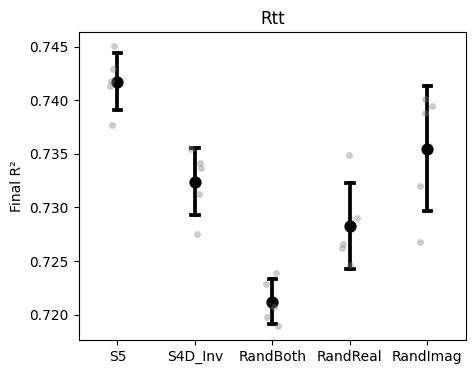

In [201]:
plot_final_r2_with_stats(df[df['dataset'] == 'mc_rtt_prepend'], x_col, order)

/tmp/ipykernel_169749/3420503884.py:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


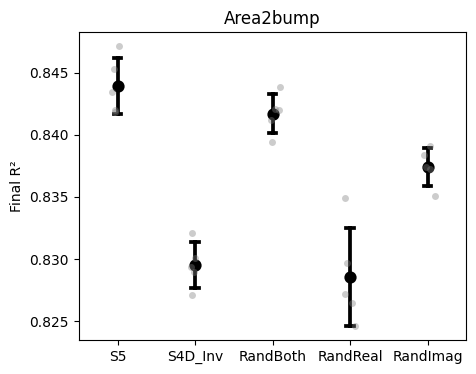

In [202]:
plot_final_r2_with_stats(df[df['dataset'] == 'mc_area2bump_prepend'], x_col, order)

# Downstream EigenSpectra Evolutions

In [185]:
_MODEL_CACHE = {}
_SPECTRA_CACHE = {}
from typing import List, Dict
import jax.numpy as jnp
from foundational_ssm.models import SSMDecoder, discretise_zoh
from foundational_ssm.utils.wandb_utils_jax import load_model_and_state_from_checkpoint_wandb

def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step)
    Lambda_bar, B_bar = discretise_zoh(Lambda, B_tilde, Delta)
    Lambda_bar = jnp.concat([Lambda_bar, jnp.conj(Lambda_bar)])

    return Lambda_bar, B_bar, C_tilde, Delta

def collect_block_spectra(model) -> List[Dict[str, np.ndarray]]:
    """For each block, return dict of arrays: A_eigs (complex), B_bar_svs, C_bar_svs, GLU_W1_svs, GLU_W2_svs."""
    blocks = []
    for block in model.ssm_blocks:
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(block.ssm)
        entry: Dict[str, np.ndarray] = {}
        # A eigenvalues (complex)
        entry["A_eigs"] = np.asarray(np.array(Lambda_bar))
        # Singular values
        try:
            entry["B_bar_svs"] = np.asarray(jnp.linalg.svd(B_bar, compute_uv=False))
        except Exception:
            entry["B_bar_svs"] = np.array([])
        try:
            entry["C_bar_svs"] = np.asarray(jnp.linalg.svd(C_tilde, compute_uv=False))
        except Exception:
            entry["C_bar_svs"] = np.array([])
        # GLU weights
        if (
            hasattr(block, "glu")
            and hasattr(block.glu, "w1")
            and hasattr(block.glu, "w2")
        ):
            try:
                entry["GLU_W1_svs"] = np.asarray(
                    jnp.linalg.svd(jnp.asarray(block.glu.w1.weight), compute_uv=False)
                )
            except Exception:
                entry["GLU_W1_svs"] = np.array([])
            try:
                entry["GLU_W2_svs"] = np.asarray(
                    jnp.linalg.svd(jnp.asarray(block.glu.w2.weight), compute_uv=False)
                )
            except Exception:
                entry["GLU_W2_svs"] = np.array([])
        else:
            entry["GLU_W1_svs"] = np.array([])
            entry["GLU_W2_svs"] = np.array([])
        blocks.append(entry)
    return blocks


def get_downstream_model(artifact_full_name):
    if artifact_full_name in _MODEL_CACHE:
        return _MODEL_CACHE[artifact_full_name]
    try:
        model, state, meta = load_model_and_state_from_checkpoint_wandb(
            artifact_full_name, model_cls=SSMDecoder
        )
        _MODEL_CACHE[artifact_full_name] = model
        return model
    except Exception as e:
        print(f"Skip {artifact_full_name}: {e}")
        _MODEL_CACHE[artifact_full_name] = None
        return None


def get_spectra(artifact_full_name):
    if artifact_full_name in _SPECTRA_CACHE:
        return _SPECTRA_CACHE[artifact_full_name]
    model = get_downstream_model(artifact_full_name)
    specs = collect_block_spectra(model)
    _SPECTRA_CACHE[artifact_full_name] = specs
    return specs

In [203]:
best_runs_per_label = df\
    .iloc[df.groupby(['label', 
                        'ssm_layer_cls', 
                        'a_initialisation', 
                        'rand_real', 
                        'rand_imag', 
                        'dataset'])['final/r2'].idxmax()]

In [204]:
best_runs_per_label

,run_id,name,state,final/r2,model/num_parameters,train/epoch_loss,dataset,ssm_layer_cls,a_initialisation,rand_real,rand_imag,learning_rate,label
16,399zr0de,mc_area2bump_prepend_ContinuousSSMLayer_s4d_in...,finished,0.843872,412546,0.323814,mc_area2bump_prepend,ContinuousSSMLayer,s4d_inv,True,True,0.045,RandBoth
35,b50etg44,mc_rtt_prepend_ContinuousSSMLayer_s4d_inv_rand...,finished,0.723874,429186,0.367984,mc_rtt_prepend,ContinuousSSMLayer,s4d_inv,True,True,0.050,RandBoth
13,ebw7ae4t,mc_area2bump_prepend_ContinuousSSMLayer_s4d_in...,finished,0.839100,412546,0.338151,mc_area2bump_prepend,ContinuousSSMLayer,s4d_inv,False,True,0.035,RandImag
29,mq0skg2c,mc_rtt_prepend_ContinuousSSMLayer_s4d_inv_rand...,finished,0.740157,429186,0.361706,mc_rtt_prepend,ContinuousSSMLayer,s4d_inv,False,True,0.050,RandImag
5,ce0meugx,mc_area2bump_prepend_ContinuousSSMLayer_s4d_in...,finished,0.834892,412546,0.306729,mc_area2bump_prepend,ContinuousSSMLayer,s4d_inv,True,False,0.050,RandReal
27,jlug1708,mc_rtt_prepend_ContinuousSSMLayer_s4d_inv_rand...,finished,0.734946,429186,0.346188,mc_rtt_prepend,ContinuousSSMLayer,s4d_inv,True,False,0.050,RandReal
1,zhv641jy,mc_area2bump_prepend_ContinuousSSMLayer_s4d_in...,finished,0.832113,412546,0.307337,mc_area2bump_prepend,ContinuousSSMLayer,s4d_inv,False,False,0.050,S4D_Inv
20,1ukt7qne,mc_rtt_prepend_ContinuousSSMLayer_s4d_inv_rand...,finished,0.735491,429186,0.347056,mc_rtt_prepend,ContinuousSSMLayer,s4d_inv,False,False,0.050,S4D_Inv
45,rcke4mpe,mc_area2bump_prepend_S5Layer_s4d_real_randImag...,finished,0.847117,412546,0.316709,mc_area2bump_prepend,S5Layer,s4d_real,True,True,0.030,S5
44,n5f7pek3,mc_rtt_prepend_S5Layer_s4d_real_randImagTrue_r...,finished,0.745047,429186,0.344383,mc_rtt_prepend,S5Layer,s4d_real,True,True,0.050,S5


Text(0.5, 1.0, 'Block 1')

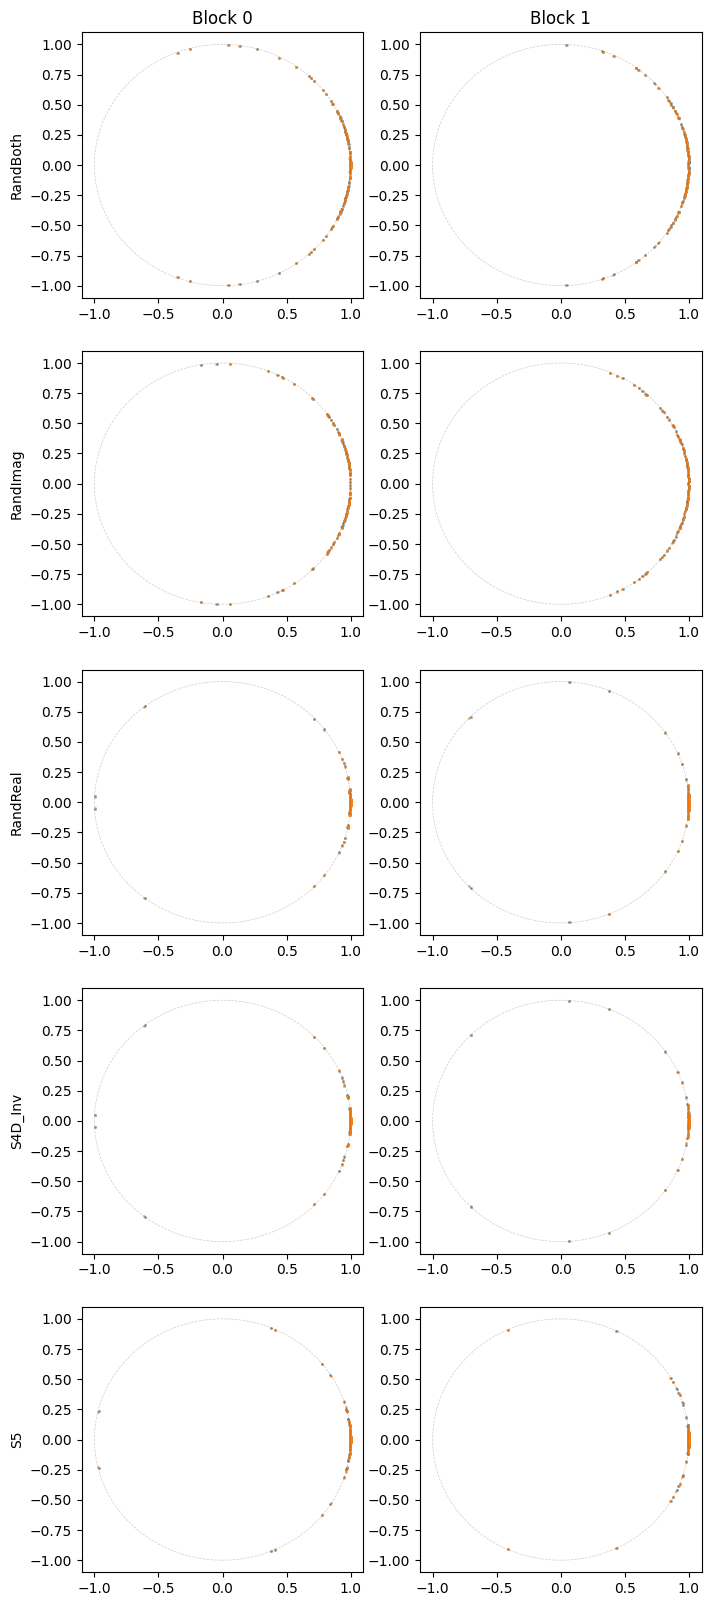

In [210]:
from types import SimpleNamespace
artifact_full_name_format = "melinajingting-ucl/foundational_ssm_downstream_sgd_sweeps/{row.dataset}_{row.ssm_layer_cls}_{row.a_initialisation}_randImag{row.rand_real}_randImag{row.rand_imag}_lr{row.learning_rate}_checkpoint:{alias}"
dataset_names = ['area2bump','mc_rtt_prepend']

best_runs_per_task = best_runs_per_label[best_runs_per_label['dataset']=='mc_area2bump_prepend']
rows = len(best_runs_per_task) 
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

# Generate points for the unit circle
theta = jnp.linspace(0, 2 * jnp.pi, 100)
unit_circle_x = jnp.cos(theta)
unit_circle_y = jnp.sin(theta)

for plt_row, (_,df_row) in enumerate(best_runs_per_task.iterrows()):
    df_row = SimpleNamespace(df_row)
    for alias in ['epoch_0','best']:
        artifact_full_name = artifact_full_name_format.format(row=df_row, alias=alias)
        spectra = get_spectra(artifact_full_name)
        for plt_col, block in enumerate(spectra):
            axs[plt_row, plt_col].scatter(block['A_eigs'].real, block['A_eigs'].imag, label='init' if alias=='epoch_0' else 'trained', alpha=0.6, s=1)
            if alias == 'epoch_0':
                axs[plt_row, plt_col].plot(unit_circle_x, unit_circle_y, color='black', linestyle='--', alpha=0.2, linewidth=0.5)
    axs[plt_row, 0].set_ylabel(df_row.label)

axs[0,0].set_title('Block 0')
axs[0,1].set_title('Block 1')
    # break

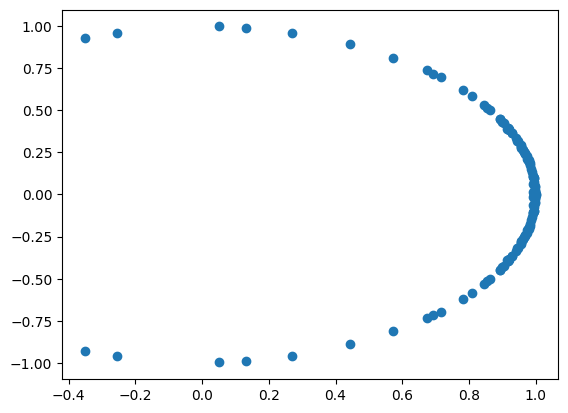

In [178]:
plt.plot(spectra[0]['A_eigs'].real, spectra[0]['A_eigs'].imag, 'o')